# Embedding

## TensorBoard 

Tutorial is available at https://www.tensorflow.org/get_started/embedding_viz.
To start TensorBoard in a docker container:

    docker exec -it <container-name> bash
    tensorboard --logdir=/data/podondra/embedding

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [2]:
# log directory for data serialization
LOG_DIR = '/tb-embedding/'

In [3]:
f = h5py.File('data/data.hdf5')
X = f['X'][...]
y = f['y'][...]
idents = f['idents'][...]

# start TensorFlow interactive session
sess = tf.InteractiveSession()

In [4]:
# clear the log directory
if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

# instatiate file TF writer
summary_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

# save labels to metadata.tsv
# format is Tab Separeted Values
# if more then one columns then first row is columns names
np.savetxt(LOG_DIR + 'metadata.tsv', y.reshape(-1, 1), fmt='%d')

# start creating config
config = projector.ProjectorConfig()

# add embeddings
def add_embedding(X, name):
    embedding_var = tf.Variable(tf.constant(X), name=name)
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name
    # link this tensor to its metadata file
    embedding.metadata_path = LOG_DIR + 'metadata.tsv'
    
add_embedding(X, 'norm')

# load the variables
sess.run(tf.global_variables_initializer())
# checkpoint the session
saver = tf.train.Saver()
saver.save(sess, LOG_DIR + 'model.ckpt', 0)

# write config
projector.visualize_embeddings(summary_writer, config)

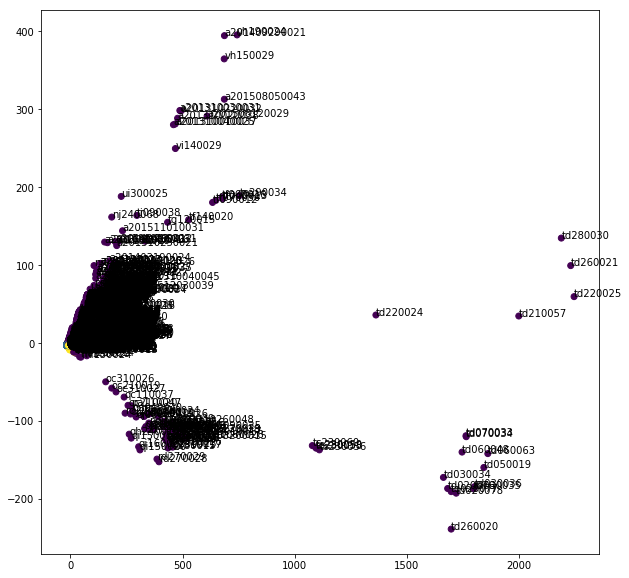

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

X_pca = PCA(n_components=2).fit_transform(X)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
for idx, ident in enumerate(idents):
    ax.annotate(ident, (X_pca[idx, 0], X_pca[idx, 1]))

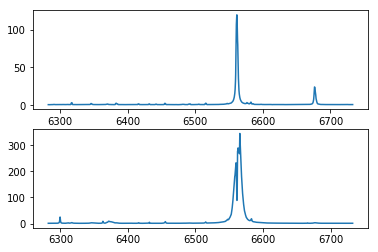

In [6]:
import spectraldl.ondrejov as ondrejov
import astropy.io.fits as fits

fig, (ax1, ax2) = plt.subplots(2, 1)

with fits.open('ssap/ui300025.fits') as hdulist:
    ondrejov.plot_spectrum(hdulist, ax1)

with fits.open('ssap/td260020.fits') as hdulist:
    ondrejov.plot_spectrum(hdulist, ax2)

In [7]:
sess.close()
f.close()